In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns


az.style.use('arviz-darkgrid')

In [2]:
WAFFLE_DATA = 'waffle_divorce.csv'
DATA_FOLDER = '../../data'

In [3]:
df_waf = pd.read_csv(f'{DATA_FOLDER}/{WAFFLE_DATA}')
df_waf.head()

,Unnamed: 0,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [4]:
df_waf['age_stan'] = (df_waf['MedianAgeMarriage'] - df_waf['MedianAgeMarriage'].mean()) / df_waf['MedianAgeMarriage'].std()
df_waf['divorce_stan'] = (df_waf['Divorce'] - df_waf['Divorce'].mean()) / df_waf['Divorce'].std()
df_waf['marriage_stan'] = (df_waf['Marriage'] - df_waf['Marriage'].mean()) /df_waf['Marriage'].std()

## Predictor Residual Plots

$$
\begin{align*}
    M_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_A \cdot A_i\\
    \alpha  & \sim N(0, 0.2) \\
    \beta_A & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.13

In [5]:
with pm.Model() as m_5_4:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1.0)
    
    mu = pm.Deterministic('mu', alpha + beta_A * df_waf['age_stan'])
    M = pm.Normal('marriage', mu=mu, sigma=sigma, observed=df_waf['marriage_stan'])
    
    trace_5_4 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 7 seconds.


In [6]:
df_tr_5_4 = pm.trace_to_dataframe(trace_5_4)
df_tr_5_4.head()

,alpha,beta_A,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,-0.034132,-0.707993,0.722820,0.395116,0.452046,0.110469,0.964411,-0.458826,0.167398,-0.914262,...,0.224328,0.452046,0.452046,1.533706,-0.515756,-0.231108,0.053539,0.565905,-0.174179,1.021341
1,-0.053447,-0.614466,0.730506,0.319097,0.368506,0.072052,0.813188,-0.422038,0.121461,-0.817310,...,0.170870,0.368506,0.368506,1.307278,-0.471447,-0.224402,0.022643,0.467324,-0.174993,0.862597
2,0.029210,-0.666945,0.647012,0.433572,0.487201,0.165428,0.969860,-0.370861,0.219057,-0.799892,...,0.272685,0.487201,0.487201,1.506149,-0.424490,-0.156345,0.111799,0.594458,-0.102717,1.023489
3,-0.052367,-0.608104,0.633847,0.316320,0.365218,0.071833,0.805295,-0.417142,0.120730,-0.808322,...,0.169628,0.365218,0.365218,1.294271,-0.466040,-0.221552,0.022935,0.463013,-0.172655,0.854193
4,-0.052367,-0.608104,0.633847,0.316320,0.365218,0.071833,0.805295,-0.417142,0.120730,-0.808322,...,0.169628,0.365218,0.365218,1.294271,-0.466040,-0.221552,0.022935,0.463013,-0.172655,0.854193


In [7]:
df_mu_5_4 = df_tr_5_4.filter(regex='(mu.*)')
df_mu_5_4.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,0.395116,0.452046,0.110469,0.964411,-0.458826,0.167398,-0.914262,-0.344967,-2.109782,-0.231108,...,0.224328,0.452046,0.452046,1.533706,-0.515756,-0.231108,0.053539,0.565905,-0.174179,1.021341
1,0.319097,0.368506,0.072052,0.813188,-0.422038,0.121461,-0.817310,-0.323220,-1.854900,-0.224402,...,0.170870,0.368506,0.368506,1.307278,-0.471447,-0.224402,0.022643,0.467324,-0.174993,0.862597
2,0.433572,0.487201,0.165428,0.969860,-0.370861,0.219057,-0.799892,-0.263603,-1.926097,-0.156345,...,0.272685,0.487201,0.487201,1.506149,-0.424490,-0.156345,0.111799,0.594458,-0.102717,1.023489
3,0.316320,0.365218,0.071833,0.805295,-0.417142,0.120730,-0.808322,-0.319347,-1.835170,-0.221552,...,0.169628,0.365218,0.365218,1.294271,-0.466040,-0.221552,0.022935,0.463013,-0.172655,0.854193
4,0.316320,0.365218,0.071833,0.805295,-0.417142,0.120730,-0.808322,-0.319347,-1.835170,-0.221552,...,0.169628,0.365218,0.365218,1.294271,-0.466040,-0.221552,0.022935,0.463013,-0.172655,0.854193


In [8]:
mu_means_5_4 = df_mu_5_4.apply(np.mean, axis=0)

mu_means_5_4[:5]

mu__0    0.419879
mu__1    0.475472
mu__2    0.141914
mu__3    0.975808
mu__4   -0.414015
dtype: float64

In [9]:
residuals_marriage = df_waf['marriage_stan'].values - mu_means_5_4.values
residuals_marriage[:5]

array([-0.39723507,  1.07432956, -0.09294011,  0.6793144 ,  0.14702556])

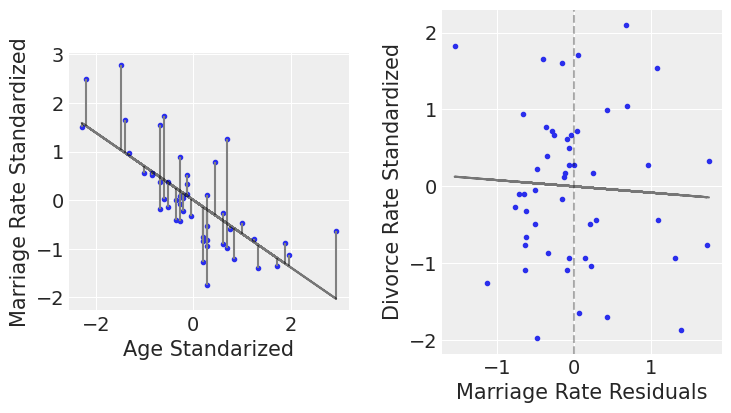

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(df_waf['age_stan'], df_waf['marriage_stan'], marker='.')
ax1.plot(df_waf['age_stan'], mu_means_5_4, 'k-', alpha=0.5)
ax1.vlines(df_waf['age_stan'], mu_means_5_4.values, mu_means_5_4.values + residuals_marriage, colors='grey')

ax1.set_xlabel('Age Standarized')
ax1.set_ylabel('Marriage Rate Standardized')
ax1.set_aspect('equal')

ax2.scatter(residuals_marriage, df_waf['divorce_stan'], marker='.')
ax2.axvline(x=0.0, ls='--', color='k', alpha=0.3)

ax2.set_xlabel('Marriage Rate Residuals')
ax2.set_ylabel('Divorce Rate Standardized')
ax2.set_aspect('equal')


m, c = np.polyfit(residuals_marriage, df_waf['divorce_stan'], deg=1)
fitted_line = [m * x + c for x in residuals_marriage]

ax2.plot(residuals_marriage, fitted_line, 'k-', alpha=0.5)

plt.show()